In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import sklearn
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score,RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.decomposition import PCA
from numpy import mean, std

In [17]:
NTS_dummy

,IndividualID,SurveyYear,Age_B04ID_4,Age_B04ID_5,Age_B04ID_6,Age_B04ID_7,Age_B04ID_8,Age_B04ID_9,Sex_B01ID_1,Sex_B01ID_2,...,std_Distance_wk,std_Distance_ex_wk,std_time_short_wk,std_time_mid_wk,std_time_long_wk,std_travel_short_wk,std_travel_mid_wk,std_travel_long_wk,Total Number of Trips,labels
0,2019011363,2019.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.000000,0.000000,0.452267,0.452267,0.000000,0.452267,0.452267,0.000000,16,3
1,2019011428,2019.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.375534,0.375534,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18,2
2,2019011564,2019.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,5.543389,5.543389,0.500000,0.516398,0.341565,0.500000,0.516398,0.341565,23,3
3,2019011569,2019.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,12.806946,12.806946,0.497245,0.000000,0.497245,0.497245,0.267261,0.513553,15,7
4,2019011570,2019.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,35.543401,35.543401,0.492366,0.389249,0.522233,0.492366,0.389249,0.522233,13,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2440,2020001977,2020.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,2.097409,2.097409,0.229416,0.229416,0.000000,0.229416,0.229416,0.000000,30,2
2441,2020002004,2020.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.404520,0.404520,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15,2
2442,2020002009,2020.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,19.442222,19.442222,0.462910,0.000000,0.462910,0.462910,0.000000,0.462910,8,7
2443,2020002010,2020.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6,7


In [18]:
NTS_dummy = pd.read_csv('/content/drive/MyDrive/socio_pred/UKDA-5340-tab/NTS_v3.csv')\
.drop(columns = ['Unnamed: 0'])
# replace NA with zero
#na occurs for std of users with one trip, or count of users with no weekend trip
NTS_dummy = NTS_dummy.fillna(0)

mobility = NTS_dummy.iloc[:,38:]
socio = NTS_dummy.drop(columns = ['IndividualID','SurveyYear']).iloc[:,0:36]

socio_cols = {'age' : socio.columns[0:6],
'sex' : socio.columns[6:7],
'marital' : socio.columns[8:9],
'income': socio.columns[10:13],
'work': socio.columns[13:16],
'hhincome': socio.columns[16:19],
'hh_struc': socio.columns[19:25],
'hh_work': socio.columns[25:28],
'hh_socialclass': socio.columns[28:34],
'urban_rural': socio.columns[34:35]}

# APPROACH 2

### Input: Subset of dependant vars
### Output: Mobility Cluster Label

In [22]:
# Train Test split
#mobility = NTS_dummy.iloc[:,38:]
socio = NTS_dummy.drop(columns = ['IndividualID','SurveyYear']).iloc[:,0:36].\
drop(columns=['Sex_B01ID_2','not_married','Settlement2011EW_B03ID_2']) # remove extra column in binary var
labels = NTS_dummy['labels']
#X_train, X_test, y_all_tr, y_all_ts = train_test_split(mobility, socio, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(socio, labels, random_state=42)

In [24]:
#normalize
scaler = MinMaxScaler().fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train),columns = X_train.columns)

#transoform test set
X_test = pd.DataFrame(scaler.transform(X_test),columns = X_test.columns)



In [46]:
X_train.columns

Index(['Age_B04ID_4', 'Age_B04ID_5', 'Age_B04ID_6', 'Age_B04ID_7',
       'Age_B04ID_8', 'Age_B04ID_9', 'Sex_B01ID_1', 'married',
       'IndIncome2002_B02ID_1', 'IndIncome2002_B02ID_2',
       'IndIncome2002_B02ID_3', 'fulltime', 'parttime', 'not_working',
       'HHIncome2002_B02ID_1', 'HHIncome2002_B02ID_2', 'HHIncome2002_B02ID_3',
       'HHoldStruct_B02ID_1', 'HHoldStruct_B02ID_2', 'HHoldStruct_B02ID_3',
       'HHoldStruct_B02ID_4', 'HHoldStruct_B02ID_5', 'HHoldStruct_B02ID_6',
       'hh_fulltime', 'hh_parttime', 'hh_not_working',
       'HRPSEGWorkStat_B01ID_1', 'HRPSEGWorkStat_B01ID_2',
       'HRPSEGWorkStat_B01ID_3', 'HRPSEGWorkStat_B01ID_4',
       'HRPSEGWorkStat_B01ID_5', 'HRPSEGWorkStat_B01ID_6',
       'Settlement2011EW_B03ID_1'],
      dtype='object')

In [ ]:
# RF for feature importance

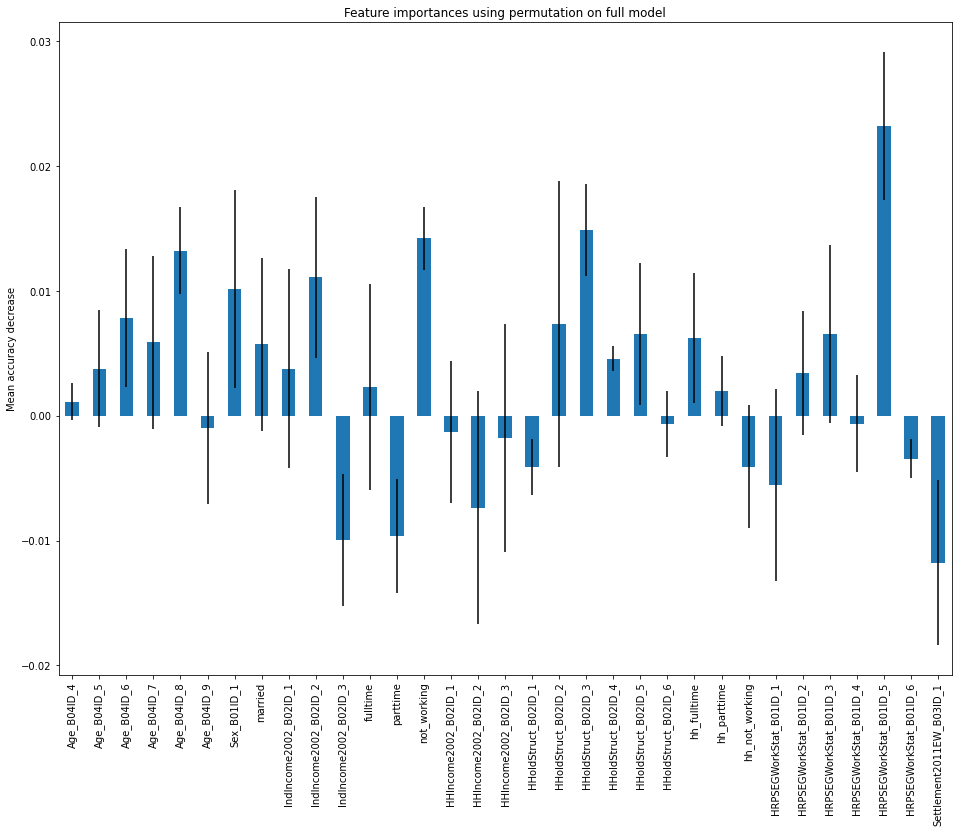

In [52]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt


model = RandomForestClassifier(random_state=42)
model.fit(X_train,y_train)
feature_names = list(X_train.columns)

result = permutation_importance(
    model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

model_importances = pd.Series(result.importances_mean, index=feature_names)

fig, ax = plt.subplots(figsize=(16, 12))
model_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
plt.show()


In [58]:
print('Random Forest Accuracy, Train Set: ')
print(acc_train)
print('Random Forest Accuracy, Test Set: ')
print(acc_test)
print('Random Forest F1 Score, Test Set: ')
print(f1_test)

Random Forest Accuracy, Train Set: 
0.7534097108565194
Random Forest Accuracy, Test Set: 
0.25326797385620914
Random Forest F1 Score, Test Set: 
0.19699336810020257


In [66]:
model_importances.sort_values()

Settlement2011EW_B03ID_1   -0.011765
IndIncome2002_B02ID_3      -0.009967
parttime                   -0.009641
HHIncome2002_B02ID_2       -0.007353
HRPSEGWorkStat_B01ID_1     -0.005556
hh_not_working             -0.004085
HHoldStruct_B02ID_1        -0.004085
HRPSEGWorkStat_B01ID_6     -0.003431
HHIncome2002_B02ID_3       -0.001797
HHIncome2002_B02ID_1       -0.001307
Age_B04ID_9                -0.000980
HRPSEGWorkStat_B01ID_4     -0.000654
HHoldStruct_B02ID_6        -0.000654
Age_B04ID_4                 0.001144
hh_parttime                 0.001961
fulltime                    0.002288
HRPSEGWorkStat_B01ID_2      0.003431
Age_B04ID_5                 0.003758
IndIncome2002_B02ID_1       0.003758
HHoldStruct_B02ID_4         0.004575
married                     0.005719
Age_B04ID_7                 0.005882
hh_fulltime                 0.006209
HHoldStruct_B02ID_5         0.006536
HRPSEGWorkStat_B01ID_3      0.006536
HHoldStruct_B02ID_2         0.007353
Age_B04ID_6                 0.007843
S

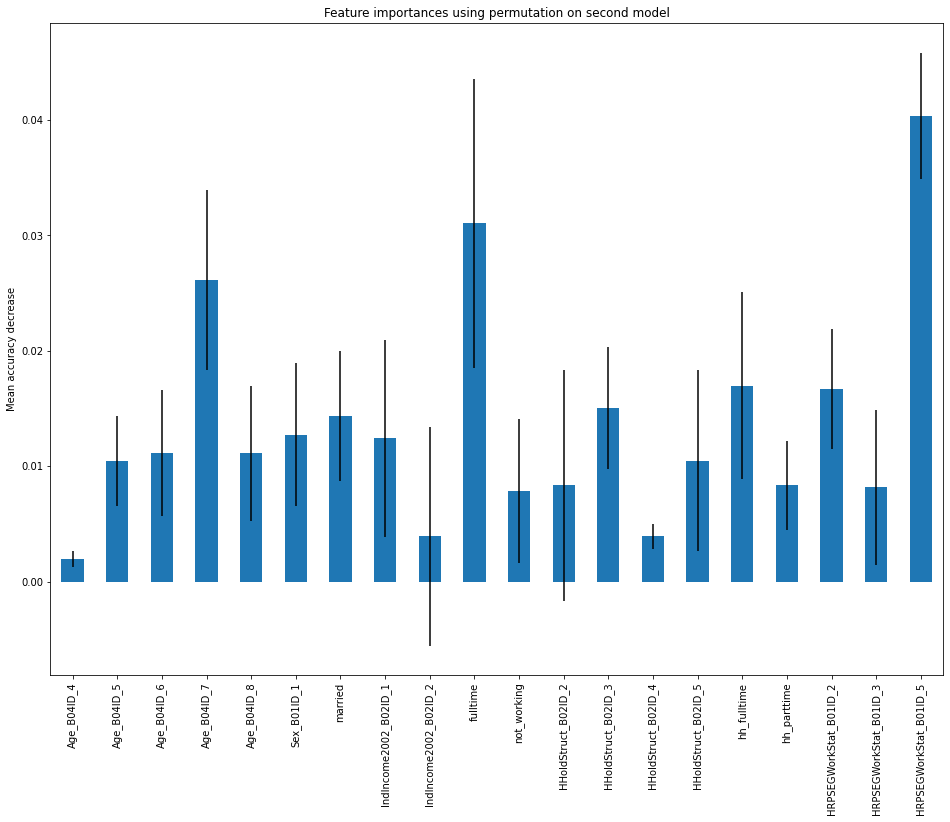

In [70]:
X_train_imp = X_train[model_importances[model_importances>0].index]
X_test_imp = X_test[model_importances[model_importances>0].index]

model = RandomForestClassifier(random_state=42)
model.fit(X_train_imp,y_train)
feature_names = list(X_train_imp.columns)

result = permutation_importance(
    model, X_test_imp, y_test, n_repeats=10, random_state=42, n_jobs=2
)

model_importances = pd.Series(result.importances_mean, index=feature_names)

fig, ax = plt.subplots(figsize=(16, 12))
model_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on second model")
ax.set_ylabel("Mean accuracy decrease")
plt.show()

In [72]:
y_pred = model.predict(X_test_imp)
y_pred_train = model.predict(X_train_imp)
acc_train = metrics.accuracy_score(y_train, y_pred_train)
acc_test = metrics.accuracy_score(y_test, y_pred)
f1_test = metrics.f1_score(y_test, y_pred, average = 'macro')

In [73]:
print('Random Forest Accuracy, Train Set: ')
print(acc_train)
print('Random Forest Accuracy, Test Set: ')
print(acc_test)
print('Random Forest F1 Score, Test Set: ')
print(f1_test)

Random Forest Accuracy, Train Set: 
0.6055646481178396
Random Forest Accuracy, Test Set: 
0.27941176470588236
Random Forest F1 Score, Test Set: 
0.20487177083597977


In [74]:
#XGBOOST
model = xgb.XGBClassifier(objective='softprob', random_state=42)
model.fit(X_train_imp,y_train)
y_pred = model.predict(X_test_imp)
y_pred_train = model.predict(X_train_imp)
acc_train = metrics.accuracy_score(y_train, y_pred_train)
acc_test = metrics.accuracy_score(y_test, y_pred)
f1_test = metrics.f1_score(y_test, y_pred, average = 'macro')


In [75]:
print('XGBOOST Accuracy, Train Set: ')
print(acc_train)
print('XGBOOST Accuracy, Test Set: ')
print(acc_test)
print('XGBOOST F1 Score, Test Set: ')
print(f1_test)

XGBOOST Accuracy, Train Set: 
0.35733769776322966
XGBOOST Accuracy, Test Set: 
0.30718954248366015
XGBOOST F1 Score, Test Set: 
0.1602087907090461


In [76]:
#all socio vars
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
acc_train = metrics.accuracy_score(y_train, y_pred_train)
acc_test = metrics.accuracy_score(y_test, y_pred)
f1_test = metrics.f1_score(y_test, y_pred, average = 'macro')
#lst = [var,acc_train,acc_test,f1_test]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
#select dependant var
def dependant(train,test,cols,var,dummy=0):
  y_train = train[cols[var]]
  y_test = test[cols[var]]
  label_encoder = LabelEncoder()

  if dummy ==1:
    #label_encoder = LabelEncoder()
    #y_train = y_train.idxmax(axis=1)
    #y_test = y_test.idxmax(axis=1)
    #label_encoder.fit(y_train)
    y_train = pd.get_dummies(y_train)
    y_test = pd.get_dummies(y_test)
  else:
    # convert to one columns labeles
    y_train = y_train.idxmax(axis=1)
    y_test = y_test.idxmax(axis=1)
    label_encoder.fit(y_train)
    y_train = label_encoder.transform(y_train)
    y_test = label_encoder.transform(y_test)

  #to get back labels
  #le.inverse_transform(y_train)
  return y_train,y_test,label_encoder

  

In [ ]:
#select dependant var
def dependant(train,test,cols,var,dummy=0):
  y_train = train[cols[var]]
  y_test = test[cols[var]]
  label_encoder = LabelEncoder()

  if dummy ==1:
    #label_encoder = LabelEncoder()
    #y_train = y_train.idxmax(axis=1)
    #y_test = y_test.idxmax(axis=1)
    #label_encoder.fit(y_train)
    y_train = pd.get_dummies(y_train)
    y_test = pd.get_dummies(y_test)
  else:
    # convert to one columns labeles
    y_train = y_train.idxmax(axis=1)
    y_test = y_test.idxmax(axis=1)
    label_encoder.fit(y_train)
    y_train = label_encoder.transform(y_train)
    y_test = label_encoder.transform(y_test)

  #to get back labels
  #le.inverse_transform(y_train)
  return y_train,y_test,label_encoder

In [ ]:
def RF(x_train,y_train,x_test,y_test,var,results):

  #no hyperparameter tuning
  model = RandomForestClassifier(n_estimators=100,n_jobs=-1, random_state=42)
  model.fit(x_train,y_train)
  y_pred = model.predict(x_test)
  y_pred_train = model.predict(x_train)
  acc_train = metrics.accuracy_score(y_train, y_pred_train)
  acc_test = metrics.accuracy_score(y_test, y_pred)
  f1_test = metrics.f1_score(y_test, y_pred, average = 'macro')

  #print('Dependant Variable <', var, ' >:')
  #print('Random Forest Accuracy, Test Set: ')
  #print(acc_test)
  #print('Random Forest F1 Score, Test Set: ')
  #print(f1_test)

  # 8-fold crossvalidation

  param_grid = {
      'max_depth': [5,10,15],
      'max_features': [4,6],
      'min_samples_leaf': [5,10],
      'min_samples_split': [5,10],
      'n_estimators': [100, 200,1000]
  }
  # Create a based model
  classifier = RandomForestClassifier()

  # Instantiate the grid search model
  grid_search = GridSearchCV(estimator = classifier, param_grid = param_grid, 
                            cv = 8, n_jobs = -1, verbose = 0)

  # Fit the grid search to the data
  #print('8-fold crossvalidation on training data: ')
  grid_search.fit(x_train,y_train)
  model = grid_search.best_estimator_
  y_pred_train = model.predict(x_train)
  y_pred_test = model.predict(x_test)
  cv_acc = metrics.accuracy_score(y_train,y_pred_train)
  cv_test = metrics.accuracy_score(y_test,y_pred_test)
  cv_f1_test = metrics.f1_score(y_test, y_pred_test, average = 'macro')
  
  #print('Best CV Accuracy: ', cv_acc)
  #print('Out of sample CV test accuracy: ',cv_test)
  lst = [var,acc_train,acc_test,f1_test,cv_acc,cv_test,cv_f1_test]
  return lst

In [ ]:
def LR(x_train,y_train,x_test,y_test,var,results):

  #no hyperparameter tuning
  model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
  model.fit(x_train,y_train)
  y_pred = model.predict(x_test)
  y_pred_train = model.predict(x_train)
  acc_train = metrics.accuracy_score(y_train, y_pred_train)
  acc_test = metrics.accuracy_score(y_test, y_pred)
  f1_test = metrics.f1_score(y_test, y_pred, average = 'macro')
  lst = [var,acc_train,acc_test,f1_test]

  #print('Dependant Variable <', var, ' >:')
  #print('Random Forest Accuracy, Test Set: ')
  #print(acc_test)
  #print('Random Forest F1 Score, Test Set: ')
  #print(f1_test)

  # 8-fold crossvalidation

  # param_grid = {
  #     'max_depth': [5,10,15],
  #     'max_features': [4,6],
  #     'min_samples_leaf': [5,10],
  #     'min_samples_split': [5,10],
  #     'n_estimators': [100, 200,1000]
  # }
  # # Create a based model
  # classifier = RandomForestClassifier()

  # # Instantiate the grid search model
  # grid_search = GridSearchCV(estimator = classifier, param_grid = param_grid, 
  #                           cv = 8, n_jobs = -1, verbose = 0)

  # # Fit the grid search to the data
  # #print('8-fold crossvalidation on training data: ')
  # grid_search.fit(x_train,y_train)
  # model = grid_search.best_estimator_
  # y_pred_train = model.predict(x_train)
  # y_pred_test = model.predict(x_test)
  # cv_acc = metrics.accuracy_score(y_train,y_pred_train)
  # cv_test = metrics.accuracy_score(y_test,y_pred_test)
  # cv_f1_test = metrics.f1_score(y_test, y_pred_test, average = 'macro')
  
  # #print('Best CV Accuracy: ', cv_acc)
  # #print('Out of sample CV test accuracy: ',cv_test)
  # lst = [var,acc_train,acc_test,f1_test,cv_acc,cv_test,cv_f1_test]
  return lst

In [ ]:
def xgboost(x_train,y_train,x_test,y_test,var,results):

  #no hyperparameter tuning\
  if len(np.unique(y_train))>2: #multiclass
    obj = "multi:softprob"
  else:
    obj = 'binary:logistic' #binary

  model = xgb.XGBClassifier(objective=obj, random_state=42)
  model.fit(x_train,y_train)
  y_pred = model.predict(x_test)
  y_pred_train = model.predict(x_train)
  acc_train = metrics.accuracy_score(y_train, y_pred_train)
  acc_test = metrics.accuracy_score(y_test, y_pred)
  f1_test = metrics.f1_score(y_test, y_pred, average = 'macro')
  lst = [var,acc_train,acc_test,f1_test]

  #print('Dependant Variable <', var, ' >:')
  #print('Random Forest Accuracy, Test Set: ')
  #print(acc_test)
  #print('Random Forest F1 Score, Test Set: ')
  #print(f1_test)

  # 8-fold crossvalidation

  # param_grid = {
  #     'max_depth': [5,10,15],
  #     'max_features': [4,6],
  #     'min_samples_leaf': [5,10],
  #     'min_samples_split': [5,10],
  #     'n_estimators': [100, 200,1000]
  # }
  # # Create a based model
  # classifier = RandomForestClassifier()

  # # Instantiate the grid search model
  # grid_search = GridSearchCV(estimator = classifier, param_grid = param_grid, 
  #                           cv = 8, n_jobs = -1, verbose = 0)

  # # Fit the grid search to the data
  # #print('8-fold crossvalidation on training data: ')
  # grid_search.fit(x_train,y_train)
  # model = grid_search.best_estimator_
  # y_pred_train = model.predict(x_train)
  # y_pred_test = model.predict(x_test)
  # cv_acc = metrics.accuracy_score(y_train,y_pred_train)
  # cv_test = metrics.accuracy_score(y_test,y_pred_test)
  # cv_f1_test = metrics.f1_score(y_test, y_pred_test, average = 'macro')
  
  # #print('Best CV Accuracy: ', cv_acc)
  # #print('Out of sample CV test accuracy: ',cv_test)
  # lst = [var,acc_train,acc_test,f1_test,cv_acc,cv_test,cv_f1_test]
  return lst

In [ ]:
def NN(x_train,y_train,x_test,y_test,var,results):
  n_features = x_train.shape[1]
  model = Sequential()
  if len(np.unique(y_train))>2: #multiclass
    act = "softmax"
  else:
    act = 'sigmoid' #binary
  out_node = y_train.shape[1]  
  model.add(Dense(12, input_shape=(n_features,), activation='relu'))
  model.add(Dense(8, activation='relu'))
  model.add(Dense(out_node, activation=act))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)


In [ ]:
#normalize
scaler = MinMaxScaler().fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train),columns = X_train.columns)
#PCA
pca = PCA(n_components=0.85) #85% of variance explained
PC_train = pca.fit_transform(X_train)

#transoform test set
X_test = pd.DataFrame(scaler.transform(X_test),columns = X_test.columns)
PC_test = pca.transform(X_test)

#principalDf = pd.DataFrame(data = principalComponents)
pca.n_components_


10

#Sociodemographic prediction: RF

In [ ]:
results = []
for var in socio_cols.keys():
  y_train,y_test, le = dependant(y_all_tr,y_all_ts,socio_cols,var)
  results.append(RF(PC_train,y_train,PC_test,y_test,var,results))



In [ ]:
RF_results = pd.DataFrame(results,columns= ['Y', 'Train Accuracy', 'Test Accuracy',\
                               'F1 Macro','CV Accuracy', 'CV Test Accuracy',\
                               'CV F1 Macro'] )


RF_results.to_csv('/content/drive/MyDrive/socio_pred/UKDA-5340-tab/RF_results.csv',\
                 index=False)
RF_results

,Y,Train Accuracy,Test Accuracy,F1 Macro,CV Accuracy,CV Test Accuracy,CV F1 Macro
0,age,0.997272,0.356209,0.213756,0.665576,0.372549,0.205859
1,sex,0.992908,0.553922,0.553911,0.660666,0.545752,0.544930
2,marital,0.997818,0.580065,0.520942,0.932897,0.584967,0.506527
3,income,0.997818,0.540850,0.359669,0.714675,0.553922,0.331274
4,work,0.998363,0.612745,0.433115,0.863066,0.638889,0.455164
5,hhincome,0.998909,0.462418,0.399601,0.828696,0.475490,0.392702
6,hh_struc,0.997818,0.380719,0.177404,0.449536,0.418301,0.130025
7,hh_work,1.000000,0.611111,0.429379,0.796508,0.616013,0.421949
8,hh_socialclass,0.998363,0.370915,0.247813,0.461538,0.385621,0.196811
9,urban_rural,1.000000,0.728758,0.454358,0.864703,0.741830,0.449427


#Sociodemographic prediction: LR

In [ ]:
results = []
for var in socio_cols.keys():
  y_train,y_test, le = dependant(y_all_tr,y_all_ts,socio_cols,var)
  results.append(LR(PC_train,y_train,PC_test,y_test,var,results))

LR_results = pd.DataFrame(results,columns= ['Y', 'Train Accuracy', 'Test Accuracy',\
                               'F1 Macro'] )


# LR_results.to_csv('/content/drive/MyDrive/socio_pred/UKDA-5340-tab/LR_results.csv',\
#                  index=False)
LR_results

,Y,Train Accuracy,Test Accuracy,F1 Macro
0,age,0.376432,0.362745,0.189356
1,sex,0.595745,0.557190,0.556990
2,marital,0.609929,0.607843,0.465284
3,income,0.584288,0.560458,0.310763
4,work,0.627932,0.620915,0.427839
5,hhincome,0.504092,0.468954,0.360260
6,hh_struc,0.415712,0.431373,0.161804
7,hh_work,0.615930,0.622549,0.414694
8,hh_socialclass,0.398254,0.379085,0.192555
9,urban_rural,0.740862,0.745098,0.426966


#Sociodemographic prediction: XGB





In [ ]:
results = []
for var in socio_cols.keys():
  y_train,y_test, le = dependant(y_all_tr,y_all_ts,socio_cols,var)
  results.append(xgboost(PC_train,y_train,PC_test,y_test,var,results))

XGB_results = pd.DataFrame(results,columns= ['Y', 'Train Accuracy', 'Test Accuracy',\
                               'F1 Macro'] )


# XGB_results.to_csv('/content/drive/MyDrive/socio_pred/UKDA-5340-tab/XGB_results.csv',\
#                  index=False)
XGB_results

,Y,Train Accuracy,Test Accuracy,F1 Macro
0,age,0.620840,0.383987,0.221601
1,sex,0.738134,0.552288,0.552288
2,marital,0.752864,0.589869,0.500389
3,income,0.690671,0.540850,0.338865
4,work,0.743044,0.632353,0.442745
5,hhincome,0.667212,0.436275,0.353806
6,hh_struc,0.573377,0.421569,0.180667
7,hh_work,0.725041,0.612745,0.411598
8,hh_socialclass,0.599564,0.379085,0.218909
9,urban_rural,0.779051,0.746732,0.473184


#Sociodemographic prediction: NN


In [ ]:
results = []
for var in socio_cols.keys():
  y_train,y_test, le = dependant(y_all_tr,y_all_ts,socio_cols,var,dummy=1)
  results.append(NN(PC_train,y_train,PC_test,y_test,var,results))

NN_results = pd.DataFrame(results,columns= ['Y', 'Train Accuracy', 'Test Accuracy',\
                               'F1 Macro'] )


# NN_results.to_csv('/content/drive/MyDrive/socio_pred/UKDA-5340-tab/NN_results.csv',\
#                  index=False)
NN_results